In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [2]:
# Set up the database connection
engine = create_engine("sqlite:///../reddit_posts.db")

In [3]:
# Read posts
posts = pd.read_sql("posts_labeled", engine)
posts.head()

,id,subreddit,date,char_len,weekday,clean_text,vader,weak_label
0,c78w4x,investing,2019-06-30,1487,Sunday,need help thinking through a long-term play on...,0.9904,positive
1,c796k7,investing,2019-06-30,49,Sunday,auction.com real estate - advice needed!,0.0000,neutral
2,c7994a,investing,2019-06-30,1053,Sunday,does anyone else think that jim rogers is righ...,-0.9683,negative
3,c79p8x,investing,2019-06-30,444,Sunday,"for the ones actively valuing companies, does ...",0.9094,positive
4,c7bgfj,investing,2019-06-30,22,Sunday,p2p investing,0.0000,neutral


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Economics'),
  Text(1, 0, 'Gold'),
  Text(2, 0, 'PoliticalDiscussion'),
  Text(3, 0, 'finance'),
  Text(4, 0, 'geopolitics'),
  Text(5, 0, 'investing')])

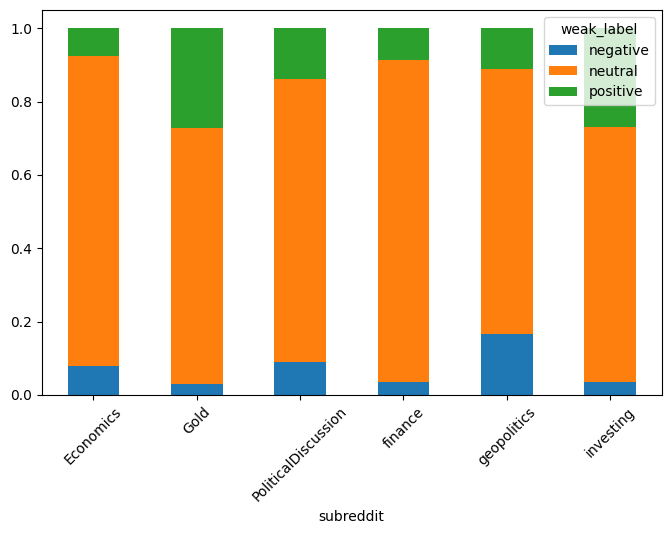

In [4]:
# Check label distribution per subreddit
subreddit_counts = posts.groupby(['subreddit', 'weak_label']).size().unstack(fill_value=0)

# Normalize the counts to get proportions
subreddit_proportions = subreddit_counts.div(subreddit_counts.sum(axis=1), axis=0)

# Plotting the proportions
subreddit_proportions.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.xticks(rotation=45)

In [5]:
# Repeat for comments
comments = pd.read_sql("comments_labeled", engine)
comments.head()

,id,subreddit,parent_id,date,char_len,clean_body,vader,weak_label
0,esdguxz,geopolitics,None,2019-06-30,9,why none?,0.0000,neutral
1,esdhtud,geopolitics,None,2019-06-30,1556,> who is the realist? it depends on what you m...,0.9092,positive
2,esdj0ib,geopolitics,None,2019-06-30,15,try outline.com,0.0000,neutral
3,esdj5ht,geopolitics,None,2019-06-30,126,russia can only be a centralized state due to ...,0.0000,neutral
4,esdj6vs,geopolitics,None,2019-06-30,143,migration is not a viable way to offset demogr...,0.0000,neutral


(array([0, 1]), [Text(0, 0, 'PoliticalDiscussion'), Text(1, 0, 'geopolitics')])

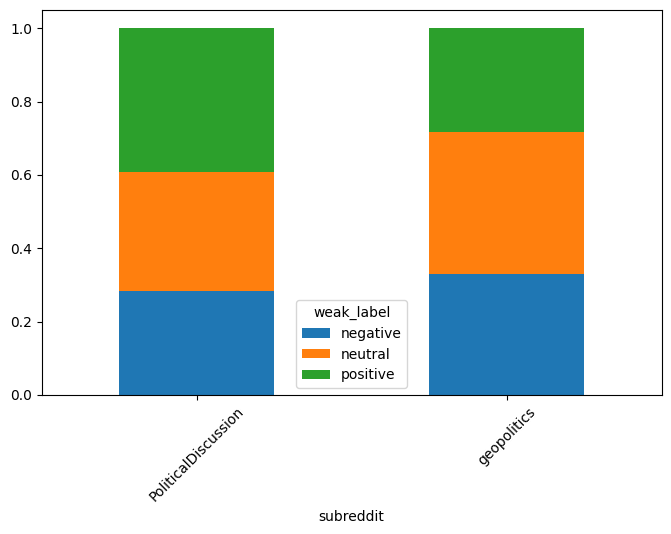

In [6]:
# Check label distribution per subreddit for comments
subreddit_counts_comments = comments.groupby(['subreddit', 'weak_label']).size().unstack(fill_value=0)

# Normalize the counts to get proportions for comments
subreddit_proportions_comments = subreddit_counts_comments.div(subreddit_counts_comments.sum(axis=1), axis=0)

# Plotting the proportions for comments
subreddit_proportions_comments.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.xticks(rotation=45)

### Moving Forward

Comments seem to be a much richer and balanced source of input, compared to the posts. On further manual review, it appears that most posts are advice-seeking and neutral in nature. The real discussion is happening in the comments, especially in discussion-heavy subreddits like the ones we have chosen. We will take only comments to be our source of input for the MVP pipeline.

In [7]:
comments.head()

,id,subreddit,parent_id,date,char_len,clean_body,vader,weak_label
0,esdguxz,geopolitics,None,2019-06-30,9,why none?,0.0000,neutral
1,esdhtud,geopolitics,None,2019-06-30,1556,> who is the realist? it depends on what you m...,0.9092,positive
2,esdj0ib,geopolitics,None,2019-06-30,15,try outline.com,0.0000,neutral
3,esdj5ht,geopolitics,None,2019-06-30,126,russia can only be a centralized state due to ...,0.0000,neutral
4,esdj6vs,geopolitics,None,2019-06-30,143,migration is not a viable way to offset demogr...,0.0000,neutral


In [13]:
# Check for gratitude in comments
import re

GRATITUDE_RE = re.compile(
    r"\b(thanks?|thank you|thx|cheers|much appreciated)\b",
    flags=re.IGNORECASE
)

# Flag comments with gratitude
comments['is_gratitude'] = comments['clean_body'].fillna('').str.contains(GRATITUDE_RE)

# Summarize
summary = (
    comments
    .groupby("subreddit")["is_gratitude"]
    .agg(total_comments="count", gratitude_count="sum")
    .reset_index()
)
summary["gratitude_pct"] = summary["gratitude_count"] / summary["total_comments"] * 100

print(summary.sort_values("gratitude_pct", ascending=False))

/var/folders/tl/w9hfhthx2q9drpztnsz6w5y80000gn/T/ipykernel_31236/1385512394.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  comments['is_gratitude'] = comments['clean_body'].fillna('').str.contains(GRATITUDE_RE)


             subreddit  total_comments  gratitude_count  gratitude_pct
0  PoliticalDiscussion         1120096            52901       4.722899
1          geopolitics          404377             7014       1.734520


In [20]:
# Average sentiment and volume per day
daily_comments = (
    comments
    .groupby(comments['date'].dt.date)
    .agg(
        comment_count=('id', 'count'),
        avg_sentiment=('vader', 'mean'),
        pos_pct=('vader', lambda x: (x > 0).mean()),
    )
    .rename_axis('date')
    .reset_index()
)
daily_comments['date'] = pd.to_datetime(daily_comments['date'])

daily_comments.head()

,date,comment_count,avg_sentiment,pos_pct
0,2019-06-30,684,0.230564,0.510234
1,2019-07-01,442,0.214992,0.524887
2,2019-07-02,599,0.091358,0.429048
3,2019-07-03,320,0.112459,0.434375
4,2019-07-04,230,0.105235,0.360870


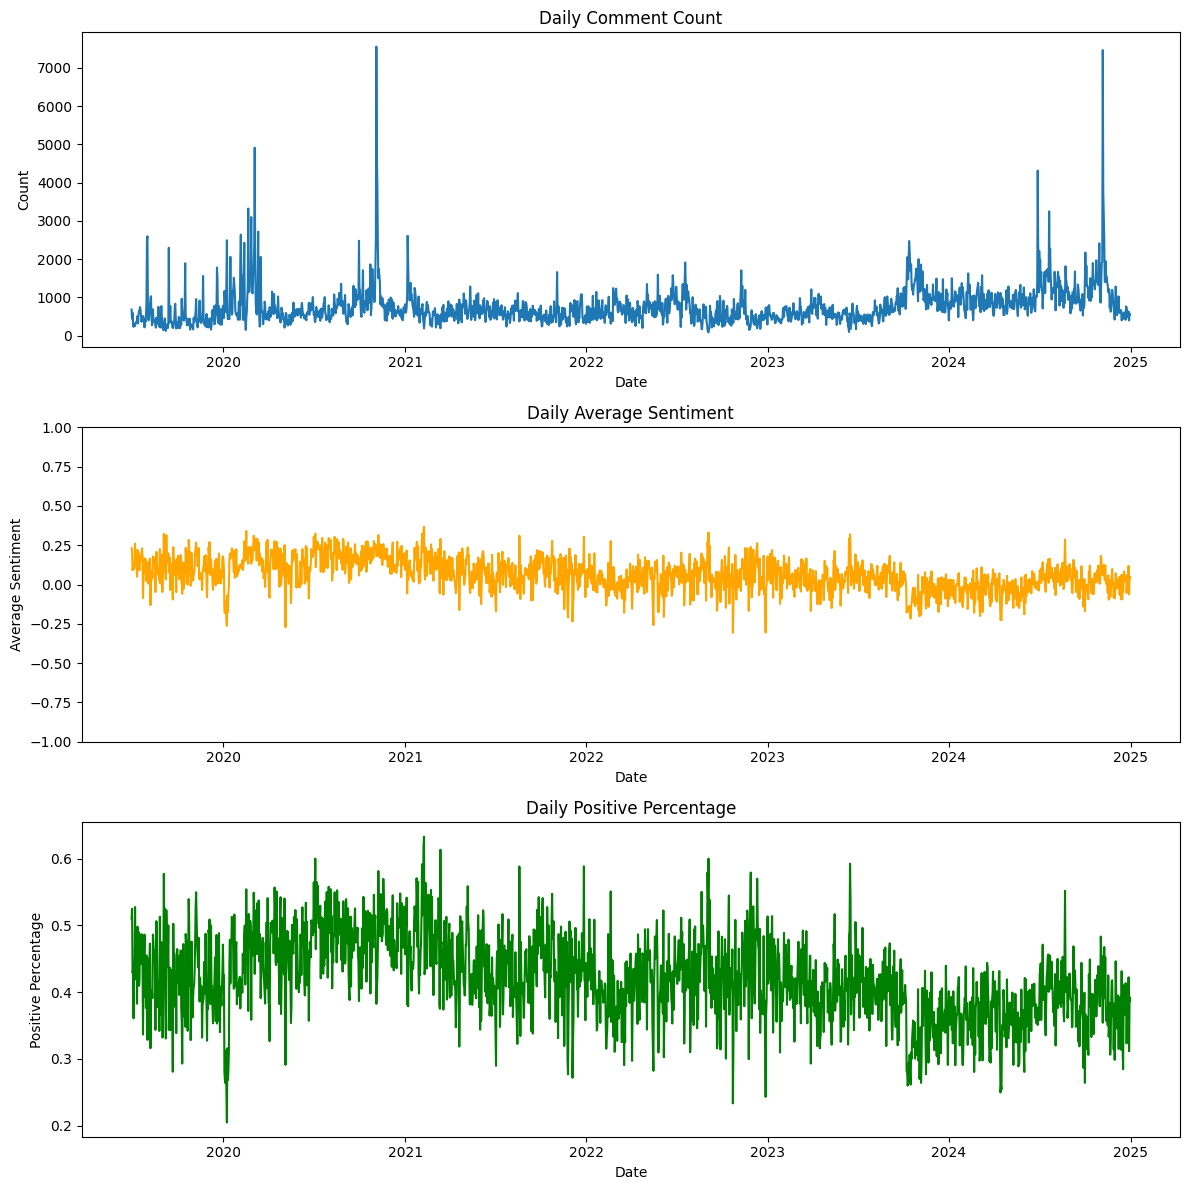

In [21]:
# Plotting daily comment statistics
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(daily_comments['date'], daily_comments['comment_count'], label='Comment Count')
plt.title('Daily Comment Count')
plt.xlabel('Date')
plt.ylabel('Count')

plt.subplot(3, 1, 2)
plt.plot(daily_comments['date'], daily_comments['avg_sentiment'], label='Average Sentiment', color='orange')
plt.title('Daily Average Sentiment')
plt.ylim([-1, 1])
plt.xlabel('Date')
plt.ylabel('Average Sentiment')

plt.subplot(3, 1, 3)
plt.plot(daily_comments['date'], daily_comments['pos_pct'], label='Positive Percentage', color='green')
plt.title('Daily Positive Percentage')
plt.xlabel('Date')
plt.ylabel('Positive Percentage')
plt.tight_layout()

In [16]:
# Compare with gold prices
gold = pd.read_sql("gold", engine)

gold.head()

,date,Close,High,Low,Open,Volume
0,2019-06-27,1408.400024,1410.800049,1399.800049,1407.000000,437
1,2019-06-28,1409.699951,1422.000000,1408.300049,1408.300049,356
2,2019-07-01,1385.599976,1395.800049,1382.800049,1386.599976,214
3,2019-07-02,1404.599976,1418.400024,1390.800049,1391.099976,38
4,2019-07-03,1417.699951,1434.000000,1413.099976,1431.000000,46


Corr(comment_sent, gold_return): -0.030600874631596393


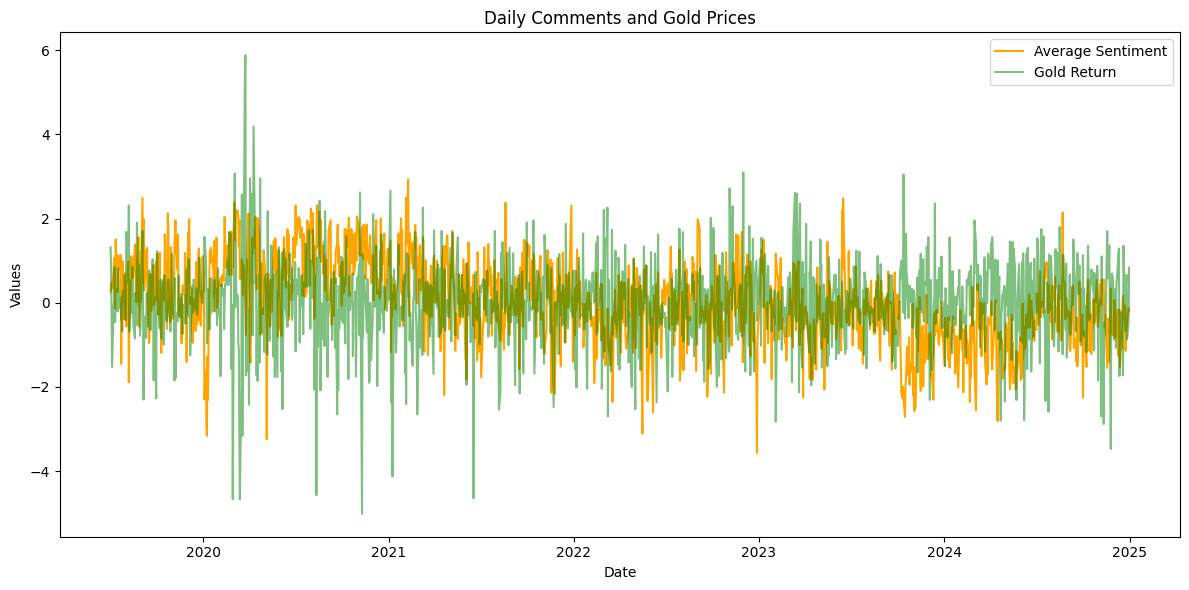

In [35]:
# Combine daily comments with gold prices
daily = (
    pd.merge(daily_comments, gold, on="date", how="inner")
    .assign(
        gold_return = lambda d: d["Close"].pct_change()
    )
    .dropna()
)

# Standardize gold return and average sentiment
daily['avg_sentiment'] = (daily['avg_sentiment'] - daily['avg_sentiment'].mean()) / daily['avg_sentiment'].std()
daily['gold_return'] = (daily['gold_return'] - daily['gold_return'].mean()) / daily['gold_return'].std()

# Plotting daily comments with gold prices
plt.figure(figsize=(12, 6))
# plt.plot(daily['date'], daily['comment_count'], label='Comment Count')
plt.plot(daily['date'], daily['avg_sentiment'], label='Average Sentiment', color='orange')
plt.plot(daily['date'], daily['gold_return'], label='Gold Return', color='green', alpha=0.5)
plt.title('Daily Comments and Gold Prices')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.tight_layout()

# Get simple correlation
print("Corr(comment_sent, gold_return):", daily["avg_sentiment"].corr(daily["gold_return"]))

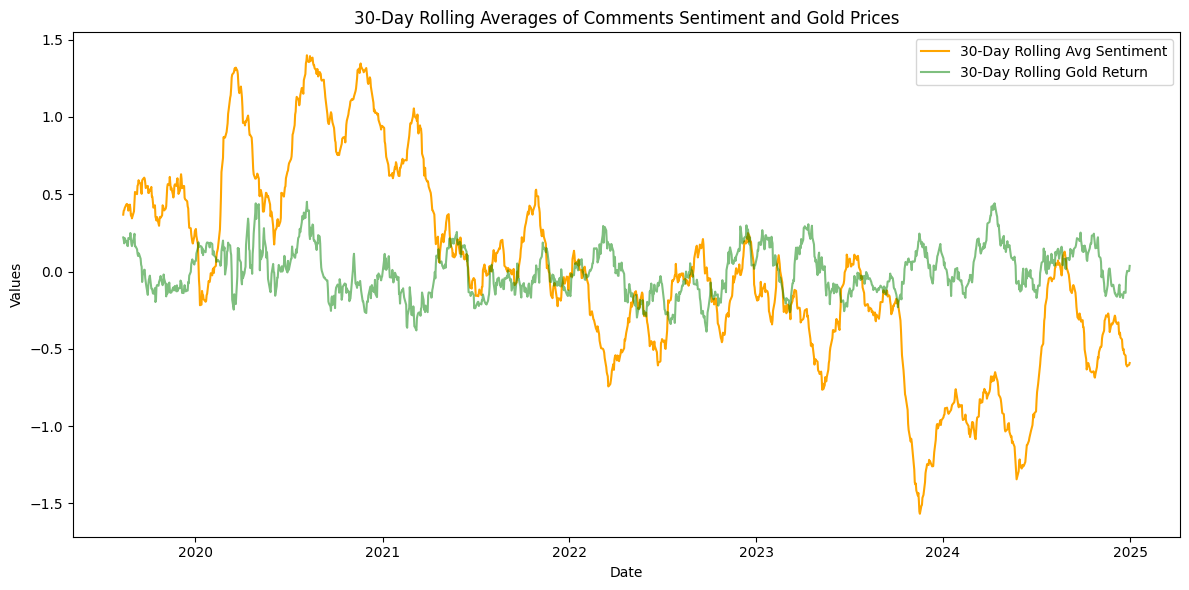

In [36]:
# Create rolling averages
daily['rolling_avg_sentiment'] = daily['avg_sentiment'].rolling(window=30).mean()
daily['rolling_gold_return'] = daily['gold_return'].rolling(window=30).mean()

# Plotting rolling averages
plt.figure(figsize=(12, 6))
plt.plot(daily['date'], daily['rolling_avg_sentiment'], label='30-Day Rolling Avg Sentiment', color='orange')
plt.plot(daily['date'], daily['rolling_gold_return'], label='30-Day Rolling Gold Return', color='green', alpha=0.5)
plt.title('30-Day Rolling Averages of Comments Sentiment and Gold Prices')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.tight_layout()
